# 0. Overview

In the dataset, each record contains a IMDB movie review and corresponding sentiment (0 for negative, 1 for positive).<br>
This notebook will use Keras LSTM model to classify the sentiment of reviews.<br>

#### 1. Load Data
a. Load IMDB review data<br>
b. Load pre-trained GloVe word embedding matrix
#### 2. Preprocessing
a. Basic preprocessing<br>
b. Decide maximum length of reviews<br>
c. Split the dataset to training and validation set<br>
d. Encode words to indices
#### 3. Build RNN with Pre-trained Embedding Layer
a. Build pre-trained GloVe embedding layer<br>
b. Build LSTM model<br>
c. Fit the model with training and validation dataset<br>
d. Search for better network architecture or better hyper-parameters
#### 4. Plot ROC

# 1. Load Data

### a. Load IMDB review data

- create a configure object containing root directory and all necessary subdirectries 

In [1]:
class Config:
    
    root_dir = 'D:\\Job\\Codes\\'
    data_dir = root_dir + 'Data\\sentiment labelled sentences\\imdb_labelled.txt'
    glove_dir = root_dir + 'Data\\sentiment labelled sentences\\glove.6B\\glove.6B.50d.txt'

config = Config

- read each line of the targeted text file

In [2]:
with open(config.data_dir, 'r', encoding = 'utf-8') as f:
    
    text = f.readlines()

- there are 1000 reviews in total

In [3]:
print('Review Number: {} records'.format(len(text)))

Review Number: 1000 records


- each line contains the movie review and the target variable sentiment (0 for negative, 1 for positive)

In [4]:
print(text[0])
print(text[1])
print(text[2])

A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  	0

Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  	0

Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  	0



### b. Load pre-trained GloVe word embedding matrix

In [5]:
import numpy as np

In [6]:
def read_glove_vecs(glove_dir):
    
    """
    Args:
        
        glove_dir (str): The directory of pre-trained GloVe word embedding matrix.
    
    Returns:
        
        word_to_index (dict): A dictionary map word to index.
        index_to_word (dict): A dictionary map index to word.
        word_to_vec_map (dict): A dictionary map word to its GloVe vector.
    """
    
    with open(glove_dir, 'r', encoding = 'utf-8') as f:
        
        # initialize words set and word_to_vec_map dictionary
        words = set()
        word_to_vec_map = {}
        
        # append each word and its vector to set and dictionary above
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype = np.float64)
            
        # initialize index word dictionary
        i = 1
        word_to_index = {}
        index_to_word = {}
        
        # append each word and its index to dictionary above
        for w in sorted(words):
            word_to_index[w] = i
            index_to_word[i] = w
            i = i + 1
    
    return word_to_index, index_to_word, word_to_vec_map

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(config.glove_dir)

- word number of the GloVe

In [8]:
print('Word Number: {}'.format(len(word_to_index)))

Word Number: 400000


- vector dimension of the GloVe

In [9]:
print('Dimension Number: {}'.format(len(word_to_vec_map['apple'])))

Dimension Number: 50


- example

In [10]:
print(word_to_index['apple'])
print(index_to_word[57797])

57797
apple


In [11]:
print(word_to_vec_map['apple'])

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


# 2. Preprocessing

In [12]:
import pandas as pd
import string
import re

### a. Basic preprocessing

- use pandas dataframe to store data
- apply necessary text cleaning process to review

In [13]:
def basic_preprocess(text):
    
    """
    Note:
        Punctuation of review would be retained and later used in RNN model.

    Args:
        text (str): A string contains review and sentiment.

    Returns:
        df (pandas dataframe): The cleaned up pandas dataframe.
    """
    
    df = pd.DataFrame({'review':text})
    
    # extract target variable (sentiment) from text, and rename the column names
    df = df.review.str.split('\t', expand = True) 
    df.rename(columns = {0:'review', 1:'sentiment'}, inplace = True)
    
    # remove \n in sentiment
    df['sentiment'] = df.sentiment.str.replace('\n', '')
    # set as int dtype
    df['sentiment'] = df.sentiment.astype('int32')
    
    # add space between punctuation and word, viewing punctuation as word
    # in bag-of-words models, punctuaction would be removed; however, in RNN punctuaction could provide information
    regex = re.compile('([{}])'.format(re.escape(string.punctuation)))
    df['review'] = df.review.apply(lambda x: regex.sub(r' \1 ', x))
    
    # remove unnecessary space and convert all words to lower case
    df['review'] = df.review.str.strip()
    df['review'] = df.review.str.lower()
    
    # take length of review
    df['sent_len'] = df.review.apply(lambda x: len(x.split()))
    
    return df

data = basic_preprocess(text)

### b. Decide maximum length of reviews

- observe the distribution of the text length to decide the maximum length of each review

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data['sent_len'].describe()

count    1000.000000
mean       17.367000
std        11.361047
min         2.000000
25%         9.000000
50%        15.000000
75%        22.250000
max        87.000000
Name: sent_len, dtype: float64

(array([312., 321., 210.,  82.,  45.,  19.,   6.,   2.,   1.,   2.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <a list of 10 Patch objects>)

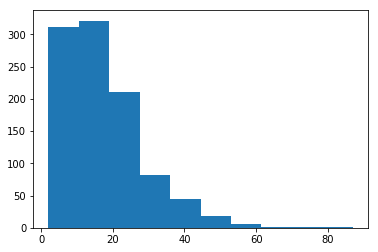

In [16]:
plt.hist(data['sent_len'])

- from the distribution above, we could observe that only small protion of reveiws have more than 40 words
- hence, we clip the maximum length of review to 40 words

In [17]:
def clip_sent_length(df, max_len):
    
    """
    Args:
        df (pandas dataframe): The cleaned up pandas dataframe.
        max_len (int): The maximum length used to clip review length.

    Returns:
        df (pandas dataframe): The pandas dataframe contains clipped reviews.
    """
    
    df['review'] = df.review.apply(lambda x: ' '.join(x.split(' ')[:max_len]))
    df['sent_len'] = df.review.apply(lambda x: len(x.split()))
    print(df['sent_len'].describe())
    
    return df

maxLen = 40
data = clip_sent_length(data, maxLen)

count    1000.000000
mean       16.717000
std         9.552809
min         2.000000
25%         9.000000
50%        15.000000
75%        22.250000
max        40.000000
Name: sent_len, dtype: float64


### c. Split the dataset to training and validation set

In [18]:
from sklearn.model_selection import train_test_split

- split to 70% training and 30% validation with stratified sampling

In [19]:
X, y = data.review, data.sentiment
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size = 0.3, 
                                                  stratify = y, 
                                                  random_state = 1)

- reset all index, enabling to encode word to index later

In [20]:
X_train.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_val.reset_index(drop = True, inplace = True)

- example number

In [21]:
print('Training Set Number: {}'.format(X_train.shape[0]))
print('Validation Set Number: {}'.format(X_val.shape[0]))

Training Set Number: 700
Validation Set Number: 300


- make sure target variable distrubtion for training set and validation set is the same
- there is no label imbalance problem

In [22]:
print(y_train.value_counts(normalize = True))

1    0.5
0    0.5
Name: sentiment, dtype: float64


In [23]:
print(y_val.value_counts(normalize = True))

1    0.5
0    0.5
Name: sentiment, dtype: float64


- example 

In [24]:
index = 4
print(X_train[index])
print(y_train[index])

it was just too horrible .
0


### d. Encode words to indices

- indices are required in Keras to build model

In [25]:
def sentences_to_indices(X, word_to_index, max_len):
        
    """
    Args:
        X (pandas series): The cleaned up pandas series contains review text.
        word_to_index (dict): The dictionary map word to index.
        max_len (int): The maximum length used to clip review length.

    Returns:
        X_indices (numpy matrix): The pandas dataframe contains clipped reviews.
    """
    
    # example number
    m = X.shape[0]
    
    # initialize the indices  matrix as a numpy array of zeros of shape(m, max_len)
    X_indices = np.zeros((m, max_len))
    
    # loop over each example
    for i in range(m):
        
        sentence_words = X[i].lower().split()
        j = 0
        
        # loop over each word
        for w in sentence_words:
            
            # if word is not in dictionary, then view it as unknown word
            if w not in word_to_index.keys():
        
                X_indices[i , j] = word_to_index['unk']
            
            else:
            
                X_indices[i , j] = word_to_index[w]
            
            j = j + 1
            
    return X_indices

X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_val_indices = sentences_to_indices(X_val, word_to_index, maxLen)

- example

In [26]:
print(X_train[index])
print(X_train_indices[index])

it was just too horrible .
[193716. 383514. 200035. 361940. 181872.    867.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.]


# 3. Build RNN with Pre-trained Embedding Layer

In [27]:
from keras.layers import Input, Activation, Dense, Dropout, BatchNormalization, LSTM, Embedding, Bidirectional
from keras.models import Model
from keras import optimizers
from keras import initializers

Using TensorFlow backend.


### a. Build pre-trained GloVe embedding layer

- to build pre-trained embedding layer, the pre-trained GloVe word embedding matrix must be built first
- then utilizing Keras Embedding layer, we could insert weights of pre-trained GloVe word embedding matrix to Keras Embedding layer

In [28]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    """
    Args:
        word_to_vec_map (dict): The dictionary maps word to corresponding GloVe vector.
        word_to_index (dict): The dictionary maps word to corresponding index.
    
    Returns:
        word_to_index (keras layer): A Keras embedding layer with pre-trained GloVe weights.
    """
    
    # adding 1 to fit Keras embedding (requirement by Keras)
    word_num = len(word_to_index) + 1
    emb_dim = word_to_vec_map['apple'].shape[0]
    
    # initialize the embedding matrix as a numpy array of zeros of shape (word_num, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((word_num, emb_dim))
    
    # insert word vector to corresponding index
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    # use Keras Embedding layer, and set the trainable = False to ensure embedding matrix won't be trained 
    embedding_layer = Embedding(input_dim = word_num, output_dim = emb_dim, trainable = False)
    
    # build the embedding layer, it is required before setting the weights of the embedding layer
    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

### b. Build LSTM model

In [29]:
def LSTM_Model(input_shape, word_to_vec_map, word_to_index):
    
    """
    Args:
        input_shape (int): The maximum length of each review text.
        word_to_vec_map (dict): The dictionary maps word to corresponding GloVe vector.
        word_to_index (dict): The dictionary maps word to corresponding index.
    
    Returns:
        model (keras model): A Keras LSTM Model.
    """
    
    # define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices)
    setence_indices = Input(shape = (input_shape,), dtype = 'int32')
    
    # create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(setence_indices)
    
    
    # propagate the embeddings through an LSTM layer with 64-dimensional hidden state
    # the returned output should be a batch of sequences
    X = Bidirectional(LSTM(64, return_sequences = True, kernel_initializer = initializers.glorot_uniform(seed = 1)))(embeddings)
    
    # propagate X through an LSTM layer with 16-dimensional hidden state
    X = Bidirectional(LSTM(16, return_sequences = False, kernel_initializer = initializers.glorot_uniform(seed = 1)))(X)
    
    # fully connect to one node, and pass to sigmoid activation layer due to binary target variable
    X = Dense(1, kernel_initializer = initializers.glorot_uniform(seed = 1))(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = setence_indices, outputs = X)
    print(model.summary())
    
    opt = optimizers.Adam(lr = adam_opt_param.learning_rate, 
                          beta_1 = adam_opt_param.beta_1, 
                          beta_2 = adam_opt_param.beta_2, 
                          epsilon = adam_opt_param.epsilon,
                          clipvalue = adam_opt_param.clipvalue)
    
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = opt,
                  metrics = ['binary_accuracy'])
    
    return model

- hyper-parameters for Adam optimizer

In [30]:
class adam_opt_param:
    
    learning_rate = 0.01
    beta_1 = 0.9
    beta_2 = 0.999 
    epsilon = 10**-8
    clipvalue = 0.5

- model summary
- 20,000,050 parameters from embedding layers are pre-trained and non-trainable

In [31]:
model = LSTM_Model(input_shape = maxLen, word_to_vec_map = word_to_vec_map, word_to_index = word_to_index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 50)            20000050  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 128)           58880     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 20,077,523
Trainable params: 77,473
Non-trainable params: 20,000,050
___________________________________________________________

### c. Fit the model with training and validation dataset

In [32]:
import tensorflow as tf

In [33]:
tf.set_random_seed(1)

history = model.fit(x = X_train_indices, y = y_train,
                    epochs = 50,
                    batch_size = 32, 
                    verbose = 2,
                    shuffle = True,
                    validation_data = (X_val_indices, y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/50
 - 4s - loss: 0.6632 - binary_accuracy: 0.6157 - val_loss: 0.6266 - val_binary_accuracy: 0.6500
Epoch 2/50
 - 1s - loss: 0.5902 - binary_accuracy: 0.6714 - val_loss: 0.4710 - val_binary_accuracy: 0.8000
Epoch 3/50
 - 1s - loss: 0.4495 - binary_accuracy: 0.8000 - val_loss: 0.4222 - val_binary_accuracy: 0.8033
Epoch 4/50
 - 1s - loss: 0.4003 - binary_accuracy: 0.8229 - val_loss: 0.4302 - val_binary_accuracy: 0.8067
Epoch 5/50
 - 1s - loss: 0.3246 - binary_accuracy: 0.8600 - val_loss: 0.4408 - val_binary_accuracy: 0.7967
Epoch 6/50
 - 1s - loss: 0.2714 - binary_accuracy: 0.8943 - val_loss: 0.4852 - val_binary_accuracy: 0.7900
Epoch 7/50
 - 1s - loss: 0.2092 - binary_accuracy: 0.9129 - val_loss: 0.5105 - val_binary_accuracy: 0.8033
Epoch 8/50
 - 1s - loss: 0.1352 - binary_accuracy: 0.9571 - val_loss: 0.6669 - val_binary_accuracy: 0.7600
Epoch 9/50
 - 1s - loss: 0.1611 - binary_accuracy: 0.9357 - val_loss: 0.5265 - val_binary_accuracy

- plot and observe training and validation error to tune hyper-parameters to reduce bias or variance

In [34]:
def plot_metric_loss(history, metrics):
    
    """
    Args:
        history (keras history): The output history of a keras model
        metrics (str): The metrics used in the fitted keras model
    
    Returns:
        None
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 6))
    
    ax1.plot(history.history[metrics])
    ax1.plot(history.history['val_' + metrics])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Val'], loc = 'upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Val'], loc = 'upper left')
    
    plt.show()

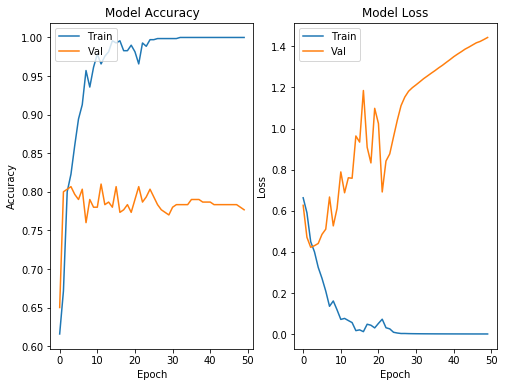

In [35]:
plot_metric_loss(history, 'binary_accuracy')

- We could observe that the LSTM is overfitting after 10 epochs since the validation error keeps rising while training error keeps reducing to almost 0.
- The solution for overfitting are 
    1. Searching for better network structure or hyper-parameters  
    2. Collecting more data  
    3. Adding more regularization 

### d. Search for better network architecture or better hyper-parameters

- Though the best solution is probably to collect more data since there are only 1000 examples here, we'll try to add more regularization to see if we could reduce the variance
- Add dropout layers with a probability of 0.5 to model

In [36]:
def LSTM_Model_Dropout(input_shape, word_to_vec_map, word_to_index):
    
    """
    Args:
        input_shape (int): The maximum length of each review text.
        word_to_vec_map (dict): The dictionary maps word to corresponding GloVe vector.
        word_to_index (dict): The dictionary maps word to corresponding index.
    
    Returns:
        model (keras model): A Keras LSTM Model.
    """
    
    # define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices)
    setence_indices = Input(shape = (input_shape,), dtype = 'int32')
    
    # create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(setence_indices)
    
    
    # propagate the embeddings through an LSTM layer with 64-dimensional hidden state
    # the returned output should be a batch of sequences
    X = Bidirectional(LSTM(64, return_sequences = True, kernel_initializer = initializers.glorot_uniform(seed = 1)))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5, seed = 1)(X)
    
    # propagate X through an LSTM layer with 16-dimensional hidden state
    X = Bidirectional(LSTM(16, return_sequences = False, kernel_initializer = initializers.glorot_uniform(seed = 1)))(X)
    X = Dropout(0.5, seed = 1)(X)
    
    # fully connect to one node, and pass to sigmoid activation layer due to binary target variable
    X = Dense(1, kernel_initializer = initializers.glorot_uniform(seed = 1))(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = setence_indices, outputs = X)
    print(model.summary())
    
    opt = optimizers.Adam(lr = adam_opt_param.learning_rate, 
                          beta_1 = adam_opt_param.beta_1, 
                          beta_2 = adam_opt_param.beta_2, 
                          epsilon = adam_opt_param.epsilon,
                          clipvalue = adam_opt_param.clipvalue)
    
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = opt,
                  metrics = ['binary_accuracy'])
    
    return model

In [37]:
model_dropout = LSTM_Model_Dropout(input_shape = maxLen, word_to_vec_map = word_to_vec_map, word_to_index = word_to_index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 50)            20000050  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 128)           58880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32)                18560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
__________

In [38]:
tf.set_random_seed(1)

history_dropout = model_dropout.fit(x = X_train_indices, y = y_train,
                                    epochs = 50,
                                    batch_size = 32, 
                                    verbose = 2,
                                    shuffle = True,
                                    validation_data = (X_val_indices, y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/50
 - 5s - loss: 0.6653 - binary_accuracy: 0.6143 - val_loss: 0.5785 - val_binary_accuracy: 0.7200
Epoch 2/50
 - 1s - loss: 0.5813 - binary_accuracy: 0.7043 - val_loss: 0.5380 - val_binary_accuracy: 0.7433
Epoch 3/50
 - 1s - loss: 0.5154 - binary_accuracy: 0.7557 - val_loss: 0.4447 - val_binary_accuracy: 0.8133
Epoch 4/50
 - 1s - loss: 0.4374 - binary_accuracy: 0.8271 - val_loss: 0.4439 - val_binary_accuracy: 0.8000
Epoch 5/50
 - 1s - loss: 0.3801 - binary_accuracy: 0.8414 - val_loss: 0.4341 - val_binary_accuracy: 0.8000
Epoch 6/50
 - 1s - loss: 0.3195 - binary_accuracy: 0.8786 - val_loss: 0.4332 - val_binary_accuracy: 0.7967
Epoch 7/50
 - 1s - loss: 0.3020 - binary_accuracy: 0.8786 - val_loss: 0.5326 - val_binary_accuracy: 0.7867
Epoch 8/50
 - 1s - loss: 0.2618 - binary_accuracy: 0.9086 - val_loss: 0.5522 - val_binary_accuracy: 0.8000
Epoch 9/50
 - 1s - loss: 0.2308 - binary_accuracy: 0.9200 - val_loss: 0.6448 - val_binary_accuracy

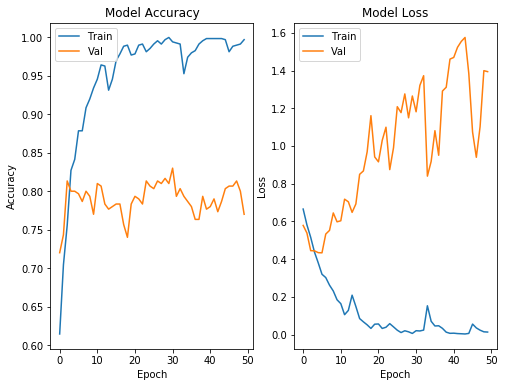

In [39]:
plot_metric_loss(history_dropout, 'binary_accuracy')

- From the above plotting, we could see that even two dropout layer with probability of 0.5 are added in the model, the overfitting and high variance problem still cannot be handled well. As a result, most likely the best solution is to collect more data.

 # 4. Plot ROC

- To better evaluate the performance of the model, we could plot the ROC of the model.

In [40]:
from sklearn.metrics import roc_curve, auc

def roc_plot(model, X_data, y_data):
    
    """
    Args:
        model (keras model): A fitted keras model.
        X_data (numpy array): A numpay array contains encoded movie reviews
        y_data (pandas series): A pandas series contains correct target variable
    
    Returns:
        None
    """
    
    # predict the probability 
    y_score = model.predict(X_data)
    
    # compute false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_data.ravel(), y_score.ravel())
    # compute AUC
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    fig, ax = plt.subplots(1, 1)
    ax.plot(fpr, tpr,
            color = 'darkorange',
            lw = lw,
            label = 'ROC Curve (AUC = {0:.3f})'.format(roc_auc))
    ax.plot([0, 1], [0, 1],
            color = 'navy',
            lw = lw, 
            linestyle = '--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('Receiver Operating Characteristic Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right') 

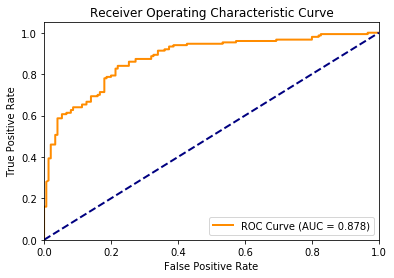

In [41]:
roc_plot(model_dropout, X_val_indices, y_val)